In [1]:
#import required packages
#basics
import pandas as pd 
import numpy as np

#misc
import gc
import time
import warnings

#stats
from scipy.misc import imread
from scipy import sparse
import scipy.stats as ss

#viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image
import matplotlib_venn as venn

#nlp
import string
import re    #for regex
import nltk
from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
# Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer   


#FeatureEngineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split





#settings
start_time=time.time()
color = sns.color_palette()
sns.set_style("dark")
eng_stopwords = set(stopwords.words("english"))
warnings.filterwarnings("ignore")

lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()

%matplotlib inline

/home/aegwyn/anaconda3/envs/tox/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-08-09 22:49:14.745520: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-09 22:49:14.746649: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2022-08-09 22:49:14.746830: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu

In [2]:
#importing the dataset
df = pd.read_csv("tweets_scored.csv")

In [3]:
#take a peak
df= df.drop(['Unnamed: 0'], axis=1)
df = df.rename(columns={'0': 'text', '1': 'category','2': 'toxicity_score','3': 'severe_toxicity_score',
                                    '4': 'identity_attack_score','5': 'profanity_score','6': 'sexually_explicit_score',
                                    '7': 'inflammatory_score','8': 'threat_score'})
df.head(10)

,text,category,toxicity_score,severe_toxicity_score,identity_attack_score,profanity_score,sexually_explicit_score,inflammatory_score,threat_score
0,Something COVID and,sports,0.285177,0.018948,0.027313,0.033199,0.050568,0.183960,0.076490
1,Did win ?,sports,0.019992,0.014548,0.028566,0.024391,0.030523,0.057584,0.059027
2,"Experience is the best teacher , Leadership qu...",sports,0.019159,0.027138,0.035382,0.044064,0.100047,0.217847,0.166869
3,".... is good , But don ' t compare him to . No...",sports,0.020825,0.021223,0.032243,0.022146,0.059694,0.090620,0.067421
4,dude just won the few ago but go keep going,sports,0.097633,0.028092,0.033517,0.038065,0.038240,0.239263,0.164319
5,Got any clips from the final ? again i forgot 😹😹,sports,0.152762,0.040662,0.076479,0.056390,0.129986,0.182876,0.130554
6,"If you ’ re this point , won 🤷🏿‍♂️",sports,0.042688,0.037090,0.052597,0.070940,0.148144,0.166914,0.143093
7,he in,sports,0.025692,0.024010,0.026248,0.050057,0.083293,0.123999,0.085639
8,Really ? Because from what I saw of him at the...,sports,0.019298,0.018325,0.039213,0.024104,0.031392,0.438301,0.044002
9,himself ’ t . Especially considering he won wi...,sports,0.035993,0.029122,0.029128,0.039653,0.039116,0.296418,0.078952


In [4]:
df['toxicity'] = df.toxicity_score.round().astype(dtype=np.int64)
df['severe_toxicity'] = df.severe_toxicity_score.round().astype(dtype=np.int64)
df['identity_attack'] = df.identity_attack_score.round().astype(dtype=np.int64)
df['profanity'] = df.profanity_score.round().astype(dtype=np.int64)
df['sexually_explicit'] = df.sexually_explicit_score.round().astype(dtype=np.int64)
df['inflammatory'] = df.inflammatory_score.round().astype(dtype=np.int64)
df['threat'] = df.threat_score.round().astype(dtype=np.int64)

In [5]:
df_b = df.drop(['toxicity_score', 'severe_toxicity_score',
                                    'identity_attack_score', 'profanity_score', 'sexually_explicit_score',
                                    'inflammatory_score', 'threat_score'], axis=1)

In [6]:
df_b.tail(10)

,text,category,toxicity,severe_toxicity,identity_attack,profanity,sexually_explicit,inflammatory,threat
5488,Entertainment and Media have made a bigger pus...,gaming,0,0,0,0,0,0,0
5489,How Can Evolve PS5 PlayStation5,gaming,0,0,0,0,0,0,0
5490,What are you doing ?👇👇👇👇👇,gaming,0,0,0,0,0,0,0
5491,I just like the game .😍,gaming,0,0,0,0,0,0,0
5492,"!, Psychonauts2 , And More",gaming,0,0,0,0,0,0,0
5493,Don ' t Skip : Fighting,gaming,0,0,0,0,0,0,0
5494,z0oinks is now streaming Super Maker 2 twitch ...,gaming,0,0,0,0,0,0,0
5495,IS LIVE ! geek,gaming,0,0,0,0,0,0,0
5496,spinning himself into a video game . game 80s ...,gaming,0,0,0,0,0,0,0
5497,We a new game .🙈🙈🙈,gaming,0,0,0,0,0,0,0


In [7]:
df_b['clean'] = 1 - (df['toxicity'] | df['severe_toxicity'] | df['identity_attack'] | df['profanity'] | df['sexually_explicit'] | df['inflammatory'] | df['threat'])

In [8]:
df_b.head(10)

,text,category,toxicity,severe_toxicity,identity_attack,profanity,sexually_explicit,inflammatory,threat,clean
0,Something COVID and,sports,0,0,0,0,0,0,0,1
1,Did win ?,sports,0,0,0,0,0,0,0,1
2,"Experience is the best teacher , Leadership qu...",sports,0,0,0,0,0,0,0,1
3,".... is good , But don ' t compare him to . No...",sports,0,0,0,0,0,0,0,1
4,dude just won the few ago but go keep going,sports,0,0,0,0,0,0,0,1
5,Got any clips from the final ? again i forgot 😹😹,sports,0,0,0,0,0,0,0,1
6,"If you ’ re this point , won 🤷🏿‍♂️",sports,0,0,0,0,0,0,0,1
7,he in,sports,0,0,0,0,0,0,0,1
8,Really ? Because from what I saw of him at the...,sports,0,0,0,0,0,0,0,1
9,himself ’ t . Especially considering he won wi...,sports,0,0,0,0,0,0,0,1


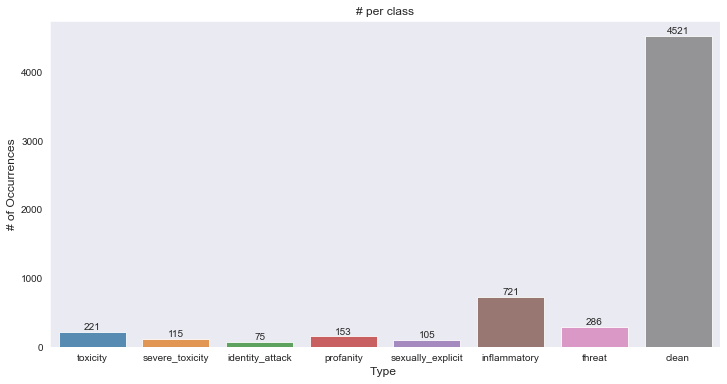

In [9]:
x = df_b.iloc[:,2:].sum()
#plot
plt.figure(figsize=(12,6))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

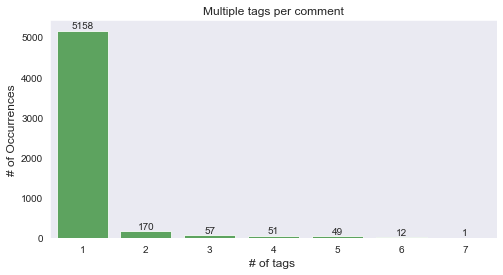

In [10]:
rowsums = df_b.iloc[:,2:].sum(axis=1)
x = rowsums.value_counts()

#plot
plt.figure(figsize=(8,4))
ax = sns.barplot(x.index, x.values, alpha=0.8,color=color[2])
plt.title("Multiple tags per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of tags ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [15]:
import plotly.graph_objects as go

In [22]:
target = (
    df_b['clean']
    .value_counts()
    .to_frame()
    .reset_index()
    .rename(columns={'index':'Target', 'clean':'Count'})
    .replace([0,1], ['Toxic', 'Clean']) 
    .groupby('Target')
    .sum()
    .reset_index()    
          )   

fig = go.Figure(data=[go.Pie(labels=target['Target'], 
                             values=target['Count'])])

fig.update_traces(hoverinfo='label',
                  textinfo='percent+value', 
                  textfont_size=20,
                  marker=dict(colors=['#8cb074', '#5a7c47'], line=dict(color='white', width=5)))

fig.update_layout(showlegend=False, 
                  title_text="Toxicity Distribution (Twitter)",
                  title_x=0.5,
                  font=dict(family="Hiragino Kaku Gothic Pro, sans-serif", size=20, color='#000000'))


fig.show()



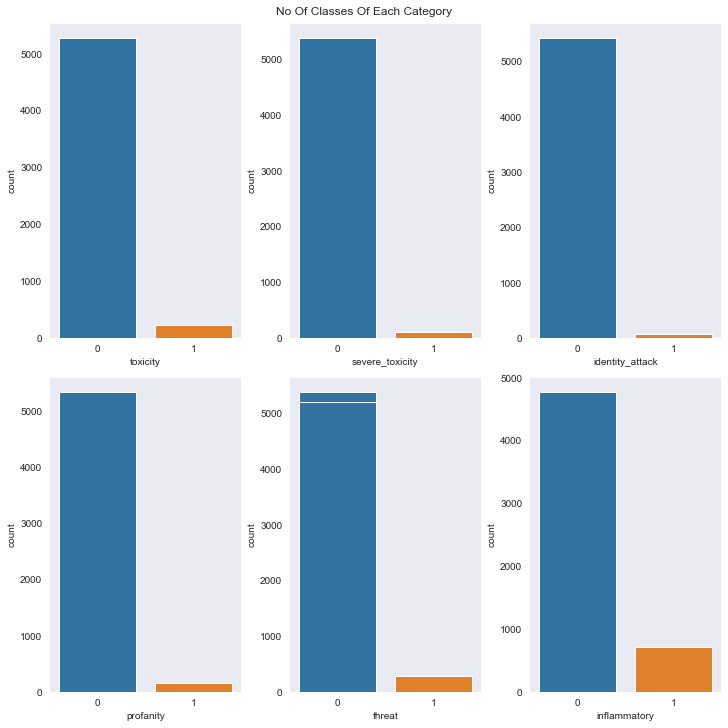

In [23]:
fig , axes = plt.subplots(2,3,figsize = (10,10), constrained_layout = True)
sns.countplot(ax=axes[0,0],x='toxicity',data=df_b )
sns.countplot(ax=axes[0,1],x='severe_toxicity',data=df_b)
sns.countplot(ax=axes[0,2],x='identity_attack',data=df_b)
sns.countplot(ax = axes[1,0],x='profanity',data=df_b)
sns.countplot(ax=axes[1,1],x='sexually_explicit',data=df_b)
sns.countplot(ax=axes[1,2],x='inflammatory',data=df_b)
sns.countplot(ax=axes[1,1],x='threat',data=df_b)
plt.suptitle('No Of Classes Of Each Category')
plt.show()

<AxesSubplot:>

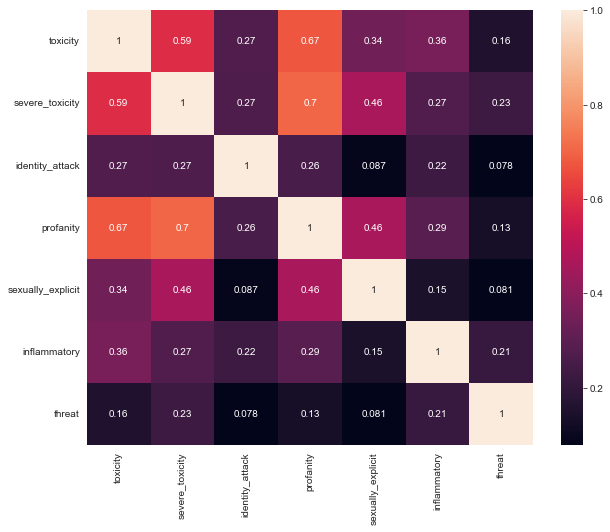

In [74]:
temp_df = df_b.iloc[:,2:-1]
# filter temp by removing clean comments
#temp_df = temp_df[~df_b.clean]

corr=temp_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

In [75]:
# https://pandas.pydata.org/pandas-docs/stable/style.html
def highlight_min(data, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_min = data == data.min()
        return [attr if v else '' for v in is_min]
    else:  # from .apply(axis=None)
        is_max = data == data.min().min()
        return pd.DataFrame(np.where(is_min, attr, ''),
                            index=data.index, columns=data.columns)

In [79]:
#Crosstab
# Since technically a crosstab between all 6 classes is impossible to vizualize, lets take a 
# look at toxic with other tags
main_col="toxicity"
corr_mats=[]
for other_col in temp_df.columns[1:]:
    confusion_matrix = pd.crosstab(temp_df[main_col], temp_df[other_col])
    corr_mats.append(confusion_matrix)
out = pd.concat(corr_mats,axis=1,keys=temp_df.columns[1:])

#cell highlighting
out = out.style.apply(highlight_min,axis=0)
out

In [80]:
#https://stackoverflow.com/questions/20892799/using-pandas-calculate-cram%C3%A9rs-coefficient-matrix/39266194
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [82]:
#Checking for Toxic and Severe toxic for now
import pandas as pd
col1="toxicity"
col2="severe_toxicity"
confusion_matrix = pd.crosstab(temp_df[col1], temp_df[col2])
print("Confusion matrix between toxic and severe toxic:")
print(confusion_matrix)
new_corr=cramers_corrected_stat(confusion_matrix)
print("The correlation between Toxic and Severe toxic using Cramer's stat=",new_corr)

Confusion matrix between toxic and severe toxic:
severe_toxicity     0   1
toxicity                 
0                5258  19
1                 125  96
The correlation between Toxic and Severe toxic using Cramer's stat= 0.5879428609931445



## Example Comments:

In [91]:
print("toxic:")
print(df_b[df_b.toxicity==1].iloc[3,0])

toxic:
calling a gamble . You ’ re stupid man . Not even argue with you any longer , you ’ t buy to start , he was bought cos and mane were at and so he can play second fiddle to them . If mane ’ t leave he ’ s the sitting his ass in bench , today 😂?


In [92]:
print("severe_toxic:")
print(df_b[df_b.severe_toxicity==1].iloc[4,0])

severe_toxic:
punching in the face after that one


In [93]:
print("Identity Attack:")
print(df_b[df_b.identity_attack==1].iloc[1,0])

Identity Attack:
won the few days ago but I ' t see them with Black majority the victory , it will always be Black wanting to mix with .


In [94]:
print("Profanity:")
print(df_b[df_b.profanity==1].iloc[1,0])

Profanity:
rage00 won , like a dick and got his country


In [95]:
print("Sexually Explicit:")
print(df_b[df_b.sexually_explicit==1].iloc[4,0])

Sexually Explicit:
is a good manager . Not great , but good . in tho ... when he was in the he ass


In [96]:
print("Inflammatory:")
print(df_b[df_b.inflammatory==1].iloc[3,0])

Inflammatory:
' t error prone . 😲 people are even this rubbish . was the most recent international tournament he since most people don ' t watch the A . how many did he commit all tournament ? . This is trying to tell you he ' s 😛


In [97]:
print("threat:")
print(df_b[df_b.threat==1].iloc[3,0])

threat:
Why should rescue the Conservative Party from it ' s own stupidity ? Would you throw them a if they were all ?


In [98]:
stopword=set(STOPWORDS)

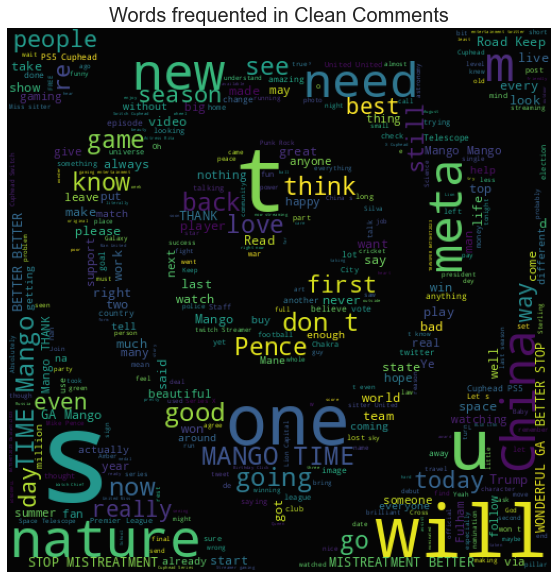

In [107]:
#clean comments
clean_mask = np.array(Image.open("input/imagesforkernal/safe-zone.png"))
clean_mask = clean_mask[:,:,1]
#wordcloud for clean comments
subset = df_b[df_b.clean == 1]
text = subset.text.values
wc = WordCloud(background_color="black",max_words=2000,mask=clean_mask,stopwords=stopword)
wc.generate(" ".join(map(str, text)))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("Words frequented in Clean Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

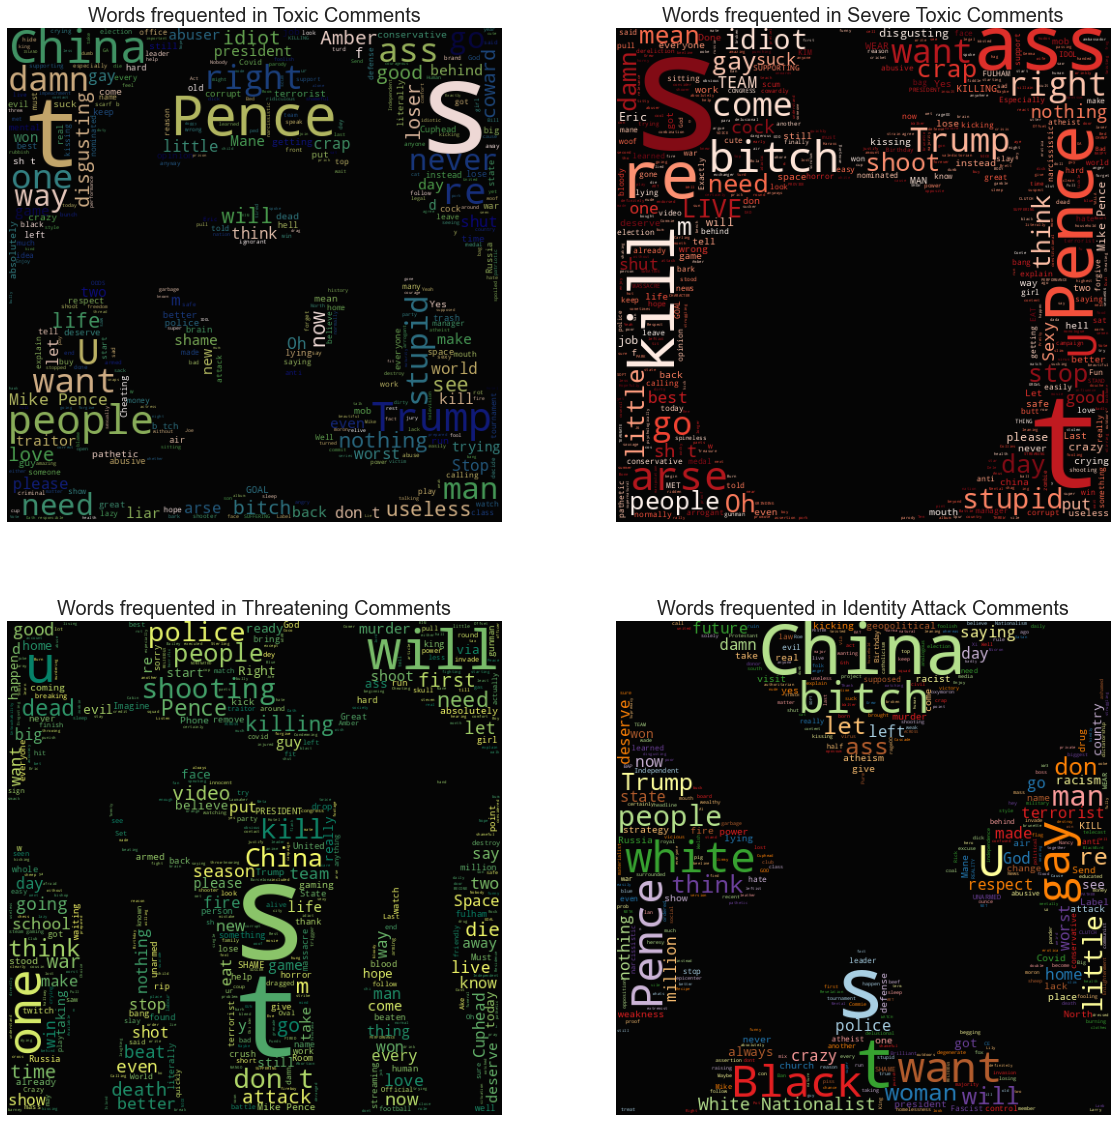

In [114]:
toxic_mask = np.array(Image.open("input/imagesforkernal/biohazard.png"))
toxic_mask = toxic_mask[:,:,1]
#wordcloud for toxic comments
subset = df_b[df_b.toxicity==1]
text = subset.text.values
wc= WordCloud(background_color="black",max_words=4000,mask=toxic_mask,stopwords=stopword)
wc.generate(" ".join(map(str, text)))
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.axis("off")
plt.title("Words frequented in Toxic Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98)

#Severely toxic comments
plt.subplot(222)
severe_toxic_mask=np.array(Image.open("input/imagesforkernal/bomb.png"))
severe_toxic_mask=severe_toxic_mask[:,:,1]
subset=df_b[df_b.severe_toxicity==1]
text=subset.text.values
wc= WordCloud(background_color="black",max_words=2000,mask=severe_toxic_mask,stopwords=stopword)
wc.generate(" ".join(map(str, text)))
plt.axis("off")
plt.title("Words frequented in Severe Toxic Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Reds' , random_state=244), alpha=0.98)

#Threat comments
plt.subplot(223)
threat_mask=np.array(Image.open("input/imagesforkernal/anger.png"))
threat_mask=threat_mask[:,:,1]
subset=df_b[df_b.threat==1]
text=subset.text.values
wc= WordCloud(background_color="black",max_words=2000,mask=threat_mask,stopwords=stopword)
wc.generate(" ".join(map(str, text)))
plt.axis("off")
plt.title("Words frequented in Threatening Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'summer' , random_state=2534), alpha=0.98)

#Identity Attack
plt.subplot(224)
identity_mask=np.array(Image.open("input/imagesforkernal/swords.png"))
identity_mask=identity_mask[:,:,1]
subset=df_b[df_b.identity_attack==1]
text=subset.text.values
wc= WordCloud(background_color="black",max_words=2000,mask=identity_mask,stopwords=stopword)
wc.generate(" ".join(map(str, text)))
plt.axis("off")
plt.title("Words frequented in Identity Attack Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Paired_r' , random_state=244), alpha=0.98)

plt.show()


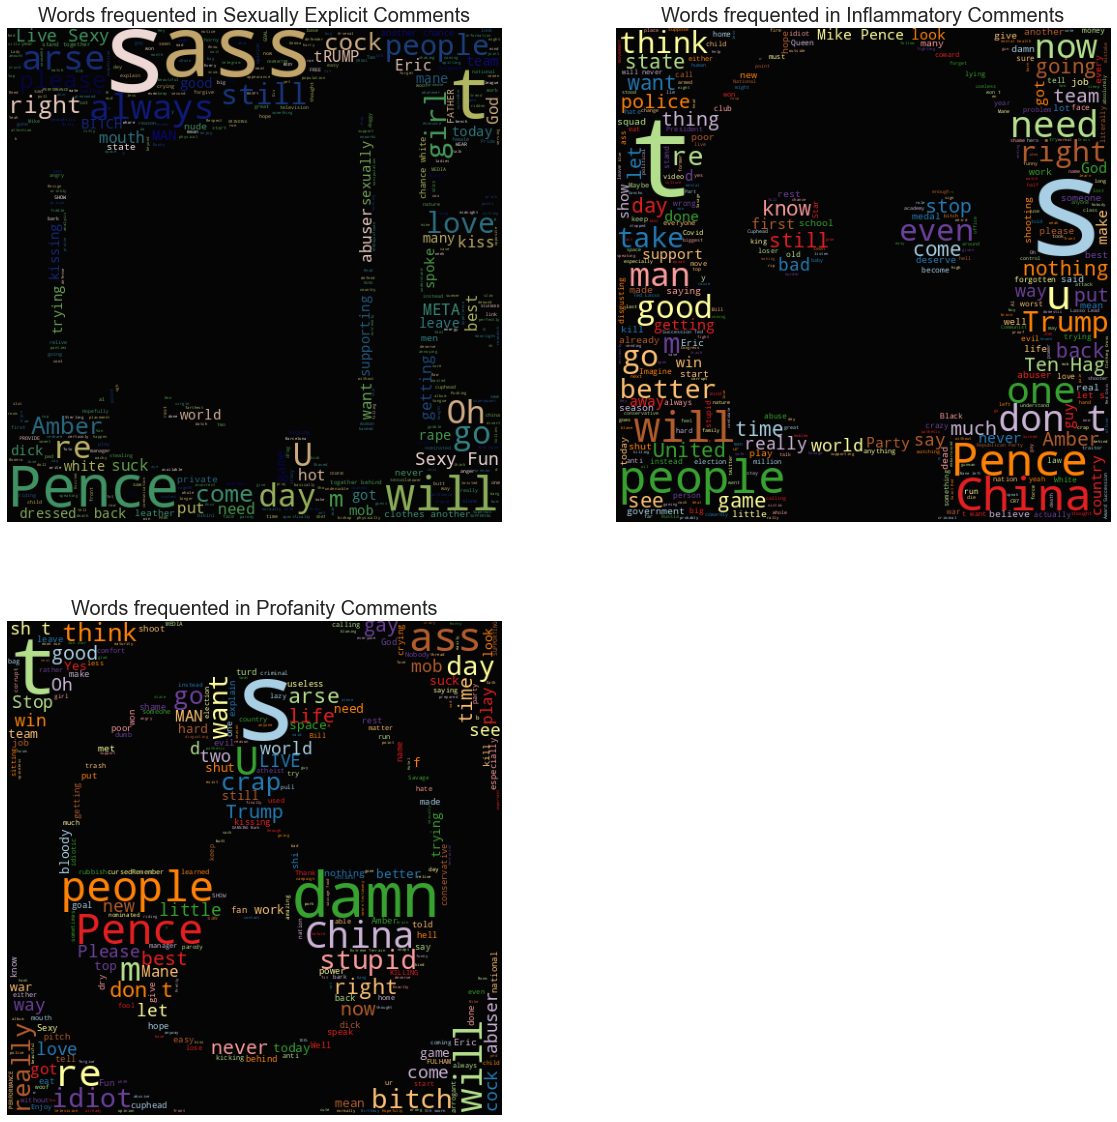

In [116]:
#Sexually Explicit
sexually_ex_mask = np.array(Image.open("input/imagesforkernal/megaphone.png"))
sexually_ex_mask = sexually_ex_mask[:,:,1]
#wordcloud for sexually explicit comments
subset = df_b[df_b.sexually_explicit==1]
text = subset.text.values
wc= WordCloud(background_color="black",max_words=4000,mask=sexually_ex_mask,stopwords=stopword)
wc.generate(" ".join(map(str, text)))
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.axis("off")
plt.title("Words frequented in Sexually Explicit Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98)

#Inflammatory
plt.subplot(222)
inflammatory_mask=np.array(Image.open("input/imagesforkernal/gas-mask.png"))
inflammatory_mask=inflammatory_mask[:,:,1]
subset=df_b[df_b.inflammatory==1]
text=subset.text.values
wc= WordCloud(background_color="black",max_words=2000,mask=inflammatory_mask,stopwords=stopword)
wc.generate(" ".join(map(str, text)))
plt.axis("off")
plt.title("Words frequented in Inflammatory Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Paired_r' , random_state=244), alpha=0.98)

#Profanity
plt.subplot(223)
profanity_mask=np.array(Image.open("input/imagesforkernal/toxic-sign.png"))
profanity_mask=profanity_mask[:,:,1]
subset=df_b[df_b.profanity==1]
text=subset.text.values
wc= WordCloud(background_color="black",max_words=2000,mask=profanity_mask,stopwords=stopword)
wc.generate(" ".join(map(str, text)))
plt.axis("off")
plt.title("Words frequented in Profanity Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Paired_r' , random_state=244), alpha=0.98)

plt.show()

In [153]:
df = df_b.iloc[:, 0:1]

In [154]:
df

,text
0,Something COVID and
1,Did win ?
2,"Experience is the best teacher , Leadership qu..."
3,".... is good , But don ' t compare him to . No..."
4,dude just won the few ago but go keep going
...,...
5493,Don ' t Skip : Fighting
5494,z0oinks is now streaming Super Maker 2 twitch ...
5495,IS LIVE ! geek
5496,spinning himself into a video game . game 80s ...


In [155]:
## Indirect features

#Sentense count in each comment:
    #  '\n' can be used to count the number of sentences in each comment
df['count_sent']=df["text"].apply(lambda x: len(re.findall("\n",str(x)))+1)
#Word count in each comment:
df['count_word']=df["text"].apply(lambda x: len(str(x).split()))
#Unique word count
df['count_unique_word']=df["text"].apply(lambda x: len(set(str(x).split())))
#Letter count
df['count_letters']=df["text"].apply(lambda x: len(str(x)))
#punctuation count
df["count_punctuations"] =df["text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
#upper case words count
df["count_words_upper"] = df["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
#title case words count
df["count_words_title"] = df["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
#Number of stopwords
df["count_stopwords"] = df["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
#Average length of the words
df["mean_word_len"] = df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [156]:
df.head()

,text,count_sent,count_word,count_unique_word,count_letters,count_punctuations,count_words_upper,count_words_title,count_stopwords,mean_word_len
0,Something COVID and,1,3,3,19,0,1,1,1,5.666667
1,Did win ?,1,3,3,9,1,0,1,1,2.333333
2,"Experience is the best teacher , Leadership qu...",1,24,19,116,4,0,2,12,3.875000
3,".... is good , But don ' t compare him to . No...",1,22,20,92,11,0,4,11,3.227273
4,dude just won the few ago but go keep going,1,10,10,43,0,0,0,5,3.400000


In [157]:
#derived features
#Word count percent in each comment:
df['word_unique_percent']=df['count_unique_word']*100/df['count_word']
#derived features
#Punct percent in each comment:
df['punct_percent']=df['count_punctuations']*100/df['count_word']

In [175]:
#serperate train and test features
df_feats=df.iloc[0:len(df_b),]
#join the tags
df_tags=df_b.iloc[:,2:10]
#print(df_feats)
print(df_tags)
df_feats=pd.concat([df_feats,df_tags],axis=1)

      toxicity  severe_toxicity  identity_attack  profanity  \
0            0                0                0          0   
1            0                0                0          0   
2            0                0                0          0   
3            0                0                0          0   
4            0                0                0          0   
...        ...              ...              ...        ...   
5493         0                0                0          0   
5494         0                0                0          0   
5495         0                0                0          0   
5496         0                0                0          0   
5497         0                0                0          0   

      sexually_explicit  inflammatory  threat  clean  
0                     0             0       0      1  
1                     0             0       0      1  
2                     0             0       0      1  
3                     0

In [176]:
#df_feats.columns = df_feats.columns.str.replace(' ', '')

In [177]:
df_feats['count_unique_word'].loc[df_feats['count_unique_word']>200] = 200
#prep for split violin plots
#For the desired plots , the data must be in long format
temp_df = pd.melt(df_feats, value_vars=['count_word', 'count_unique_word'], id_vars='clean')
#spammers - comments with less than 40% unique words
spammers=df_feats[df_feats['word_unique_percent']<30]

In [183]:
spammers.text

1756                                        , , , , , , .
3115    Arsenal have reportedly ... , , , , , , epl202...
4685    Lay ' s blood type is A , ' s blood type is O ...
Name: text, dtype: object

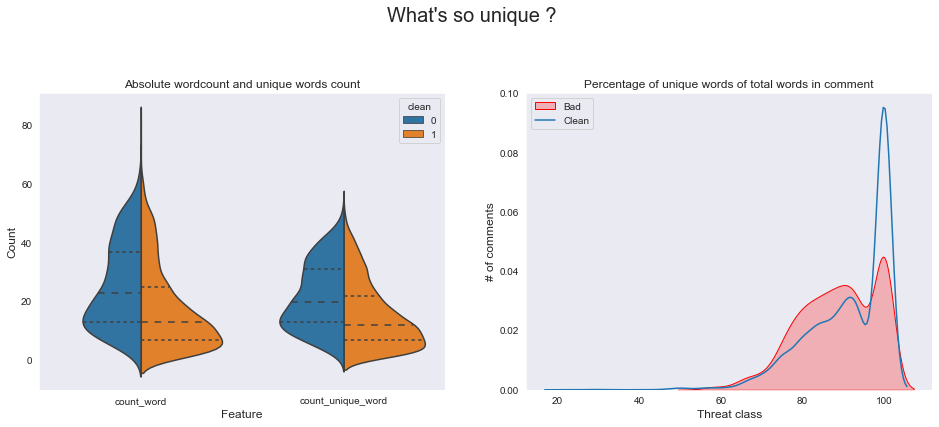

In [184]:
plt.figure(figsize=(16,12))
plt.suptitle("What's so unique ?",fontsize=20)
gridspec.GridSpec(2,2)
plt.subplot2grid((2,2),(0,0))
sns.violinplot(x='variable', y='value', hue='clean', data=temp_df,split=True,inner='quartile')
plt.title("Absolute wordcount and unique words count")
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.subplot2grid((2,2),(0,1))
plt.title("Percentage of unique words of total words in comment")
#sns.boxplot(x='clean', y='word_unique_percent', data=train_feats)
ax=sns.kdeplot(df_feats[df_feats.clean == 0].word_unique_percent, label="Bad",shade=True,color='r')
ax=sns.kdeplot(df_feats[df_feats.clean == 1].word_unique_percent, label="Clean")
plt.legend()
plt.ylabel('Number of occurances', fontsize=12)
plt.xlabel('Percent unique words', fontsize=12)


#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.xlabel('Threat class', fontsize=12)
plt.ylabel('# of comments', fontsize=12)
plt.show()

In [193]:
spammers.toxicity

1756    0
3115    0
4685    0
Name: toxicity, dtype: int64

In [195]:
print("Clean Spam example:")
print(spammers[spammers.clean==1].text.iloc[0])
# print("Toxic Spam example:")
# print(spammers[spammers.toxicity==1].text.iloc[0])

Clean Spam example:
, , , , , , .


In [186]:
df_b.head()

,text,category,toxicity,severe_toxicity,identity_attack,profanity,sexually_explicit,inflammatory,threat,clean,...,count_word,count_unique_word,count_letters,count_punctuations,count_words_upper,count_words_title,count_stopwords,mean_word_len,word_unique_percent,punct_percent
0,Something COVID and,sports,0,0,0,0,0,0,0,1,...,3,3,19,0,1,1,1,5.666667,100.000000,0.000000
1,Did win ?,sports,0,0,0,0,0,0,0,1,...,3,3,9,1,0,1,1,2.333333,100.000000,33.333333
2,"Experience is the best teacher , Leadership qu...",sports,0,0,0,0,0,0,0,1,...,24,19,116,4,0,2,12,3.875000,79.166667,16.666667
3,".... is good , But don ' t compare him to . No...",sports,0,0,0,0,0,0,0,1,...,22,20,92,11,0,4,11,3.227273,90.909091,50.000000
4,dude just won the few ago but go keep going,sports,0,0,0,0,0,0,0,1,...,10,10,43,0,0,0,5,3.400000,100.000000,0.000000


In [187]:
corpus = df_b.text

In [188]:
#https://drive.google.com/file/d/0B1yuv8YaUVlZZ1RzMFJmc1ZsQmM/view
# Aphost lookup dict
APPO = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying"
}

In [189]:
def clean(comment):
    """
    This function receives comments and returns clean word-list
    """
    #Convert to lower case , so that Hi and hi are the same
    comment=comment.lower()
    #remove \n
    comment=re.sub("\\n","",comment)
    # remove leaky elements like ip,user
    comment=re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}","",comment)
    #removing usernames
    comment=re.sub("\[\[.*\]","",comment)
    
    #Split the sentences into words
    words=tokenizer.tokenize(comment)
    
    # (')aphostophe  replacement (ie)   you're --> you are  
    # ( basic dictionary lookup : master dictionary present in a hidden block of code)
    words=[APPO[word] if word in APPO else word for word in words]
    words=[lem.lemmatize(word, "v") for word in words]
    words = [w for w in words if not w in eng_stopwords]
    
    clean_sent=" ".join(words)
    # remove any non alphanum,digit character
    #clean_sent=re.sub("\W+"," ",clean_sent)
    #clean_sent=re.sub("  "," ",clean_sent)
    return(clean_sent)

In [199]:
corpus.iloc[200]

'The pillar built during the reign of Emperor can be mainly divided into five . 1 . Shaft 2 . Bell shaped vase covered with inverted lotus 3 . Abacus 4 . Capital 5 . Wheel'

In [200]:
clean(corpus.iloc[200])

'pillar build reign emperor mainly divide five . 1 . shaft 2 . bell shape vase cover invert lotus 3 . abacus 4 . capital 5 . wheel'

In [203]:
clean_corpus=corpus.apply(lambda x :clean(str(x)))

end_time=time.time()
print("total time till Cleaning",end_time-start_time)

total time till Cleaning 19732.408432006836


In [204]:
clean_corpus

0                                         something covid
1                                                   win ?
2       experience best teacher , leadership quality ,...
3         ... good , ' compare . anyway . win central ...
4                                 dude win ago go keep go
                              ...                        
5493                                       ' skip : fight
5494    z0oinks stream super maker 2 twitch streamer g...
5495                                          live ! geek
5496    spin video game . game 80s unity action concep...
5497                                     new game . 🙈 🙈 🙈
Name: text, Length: 5498, dtype: object

In [205]:
# To do next:
# Slang lookup dictionary for sentiments
#http://slangsd.com/data/SlangSD.zip
#http://arxiv.org/abs/1608.05129
# dict lookup 
#https://bytes.com/topic/python/answers/694819-regular-expression-dictionary-key-search


In [239]:
### Unigrams -- TF-IDF 
# using settings recommended here for TF-IDF -- https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle

#some detailed description of the parameters
# min_df=10 --- ignore terms that appear lesser than 10 times 
# max_features=None  --- Create as many words as present in the text corpus
    # changing max_features to 10k for memmory issues
# analyzer='word'  --- Create features from words (alternatively char can also be used)
# ngram_range=(1,1)  --- Use only one word at a time (unigrams)
# strip_accents='unicode' -- removes accents
# use_idf=1,smooth_idf=1 --- enable IDF
# sublinear_tf=1   --- Apply sublinear tf scaling, i.e. replace tf with 1 + log(tf)


#temp settings to min=200 to facilitate top features section to run in kernals
#change back to min=10 to get better results
start_unigrams=time.time()
tfv = TfidfVectorizer(min_df=200,  max_features=1000, 
            strip_accents='unicode', analyzer='word',ngram_range=(1,1),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')
tfv.fit(clean_corpus)
features = np.array(tfv.get_feature_names())

df_unigrams =  tfv.transform(clean_corpus.iloc[:df_b.shape[0]])

In [240]:
#https://buhrmann.github.io/tfidf-analysis.html
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

def top_mean_feats(Xtr, features, grp_ids, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    
    D = Xtr[grp_ids].toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

# modified for multilabel milticlass
def top_feats_by_class(Xtr, features, min_tfidf=0.1, top_n=20):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    cols=df_tags.columns
    for col in cols:
        ids = df_tags.index[df_tags[col]==1]
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        print(col)
        dfs.append(feats_df)
    return dfs

In [241]:
#get top n for unigrams
tfidf_top_n_per_lass=top_feats_by_class(df_unigrams,features)

end_unigrams=time.time()

print("total time in unigrams",end_unigrams-start_unigrams)
print("total time till unigrams",end_unigrams-start_time)


toxicity
severe_toxicity
identity_attack
profanity
sexually_explicit
inflammatory
threat
clean
total time in unigrams 2.2221429347991943
total time till unigrams 20559.238659620285


In [242]:
features

array(['china', 'cuphead', 'game', 'like', 'mango', 'nature', 'pence',
       'think', 'time', 'win'], dtype='<U7')

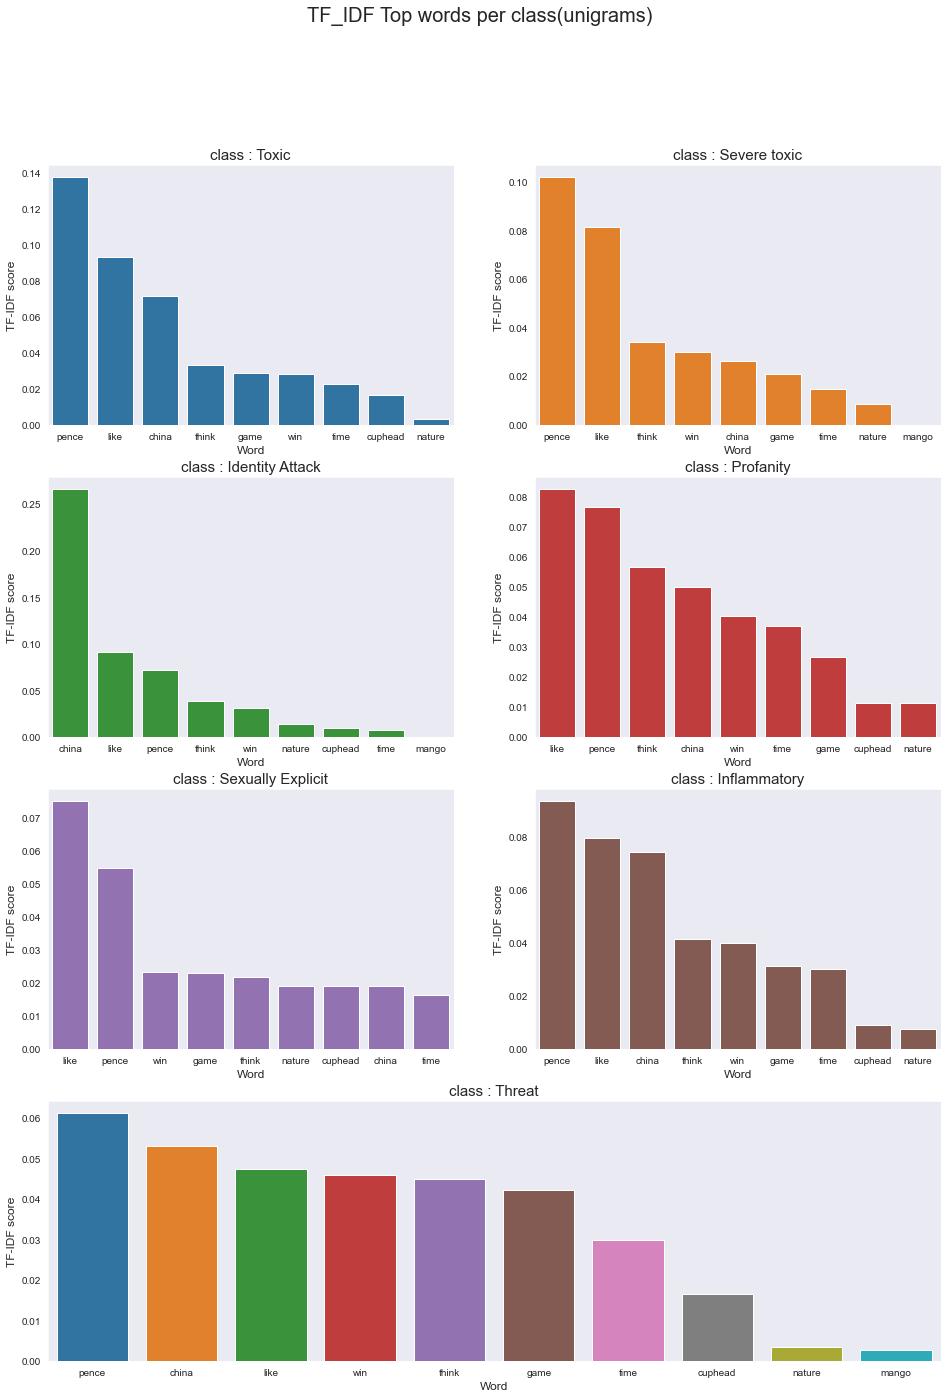

In [243]:
plt.figure(figsize=(16,22))
plt.suptitle("TF_IDF Top words per class(unigrams)",fontsize=20)
gridspec.GridSpec(4,2)
plt.subplot2grid((4,2),(0,0))
sns.barplot(tfidf_top_n_per_lass[0].feature.iloc[0:9],tfidf_top_n_per_lass[0].tfidf.iloc[0:9],color=color[0])
plt.title("class : Toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.subplot2grid((4,2),(0,1))
sns.barplot(tfidf_top_n_per_lass[1].feature.iloc[0:9],tfidf_top_n_per_lass[1].tfidf.iloc[0:9],color=color[1])
plt.title("class : Severe toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,0))
sns.barplot(tfidf_top_n_per_lass[2].feature.iloc[0:9],tfidf_top_n_per_lass[2].tfidf.iloc[0:9],color=color[2])
plt.title("class : Identity Attack",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,1))
sns.barplot(tfidf_top_n_per_lass[3].feature.iloc[0:9],tfidf_top_n_per_lass[3].tfidf.iloc[0:9],color=color[3])
plt.title("class : Profanity",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,0))
sns.barplot(tfidf_top_n_per_lass[4].feature.iloc[0:9],tfidf_top_n_per_lass[4].tfidf.iloc[0:9],color=color[4])
plt.title("class : Sexually Explicit",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,1))
sns.barplot(tfidf_top_n_per_lass[5].feature.iloc[0:9],tfidf_top_n_per_lass[5].tfidf.iloc[0:9],color=color[5])
plt.title("class : Inflammatory",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(3,0),colspan=2)
sns.barplot(tfidf_top_n_per_lass[6].feature.iloc[0:19],tfidf_top_n_per_lass[6].tfidf.iloc[0:19])
plt.title("class : Threat",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.show()

In [ ]:
fig, axes = plt.subplots(ncols=6, figsize=(18, 50), dpi=100)
plt.tight_layout()

N = 100
sns.barplot(y=toxic_unigrams_df[0].values[:N], x=toxic_unigrams_df[1].values[:N], ax=axes[0])
sns.barplot(y=severe_toxic_unigrams_df[0].values[:N], x=severe_toxic_unigrams_df[1].values[:N], ax=axes[1])
sns.barplot(y=obscene_unigrams_df[0].values[:N], x=obscene_unigrams_df[1].values[:N], ax=axes[2])
sns.barplot(y=threat_unigrams_df[0].values[:N], x=threat_unigrams_df[1].values[:N], ax=axes[3])
sns.barplot(y=insult_unigrams_df[0].values[:N], x=insult_unigrams_df[1].values[:N], ax=axes[4])
sns.barplot(y=identity_hate_unigrams_df[0].values[:N], x=identity_hate_unigrams_df[1].values[:N], ax=axes[5])

for i in range(6):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} Toxic Comments', fontsize=15)
axes[1].set_title(f'Top {N} Severe Toxic Comments', fontsize=15)
axes[2].set_title(f'Top {N} Obsece Comments', fontsize=15)
axes[3].set_title(f'Top {N} Threat Comments', fontsize=15)
axes[4].set_title(f'Top {N} Insult Comments', fontsize=15)
axes[5].set_title(f'Top {N} Identity Hate Comments', fontsize=15)

plt.show()